# Portfolio Simulation Notebook
This notebook simulates a multi-asset portfolio using Monte Carlo and Geometric Brownian Motion.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from scipy.stats import norm


In [2]:
# Define assets and their tickers
stocklist = ['NESN', 'VOW3', 'KO', 'ROG', 'JNJ'] 
stocks = ['NESN.SW', 'VOW3.DE', 'KO', 'ROG.SW', 'JNJ'] 

# Define timeframe (past 1 year)
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365)


In [3]:
# Download historical stock prices
stock_prices = yf.download(stocks, start=start_date, end=end_date, auto_adjust=True)['Close'].dropna()

# Calculate daily returns, mean returns, and covariance matrix
returns = stock_prices.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Download SPY benchmark prices
spy_prices = yf.download('SPY', start=start_date, end=end_date, auto_adjust=True)['Close'].dropna()


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
def geometric_brownian_motion(S0, mu, sigma, T, dt=1/252, n_paths=200): 
    Z = np.random.normal(size=(T, n_paths)) 
    W = np.zeros((T, n_paths)) 
    W[1:] = np.cumsum(np.sqrt(dt) * Z[1:], axis=0)
    t = np.linspace(0, T * dt, T) 
    S = S0 * np.exp((mu - 0.5 * sigma**2) * t[:, None] + sigma * W)
    return S


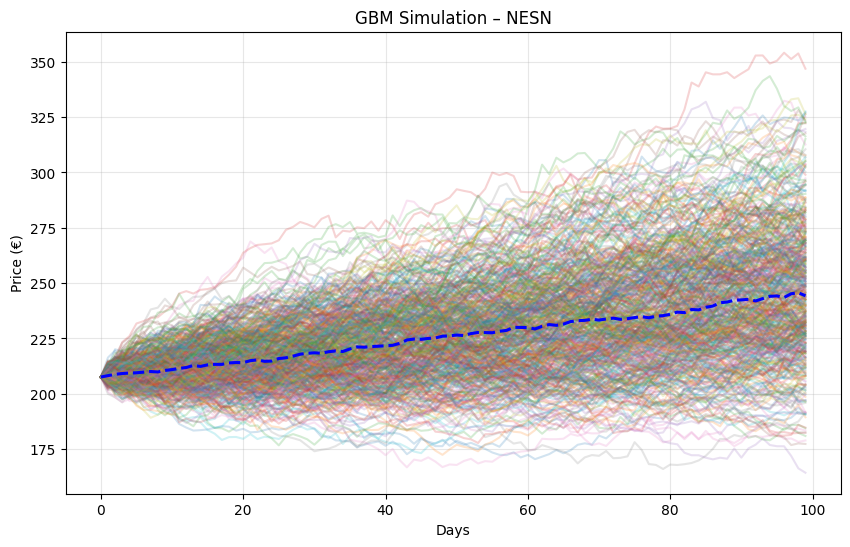

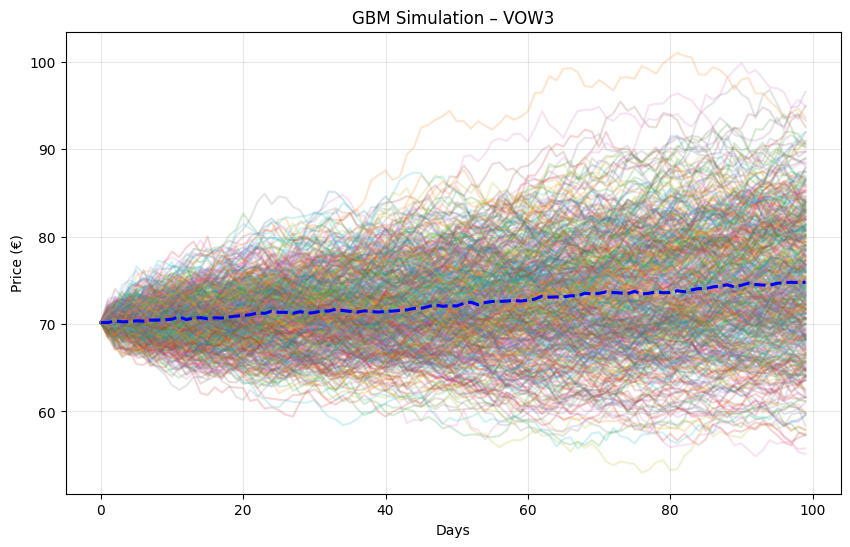

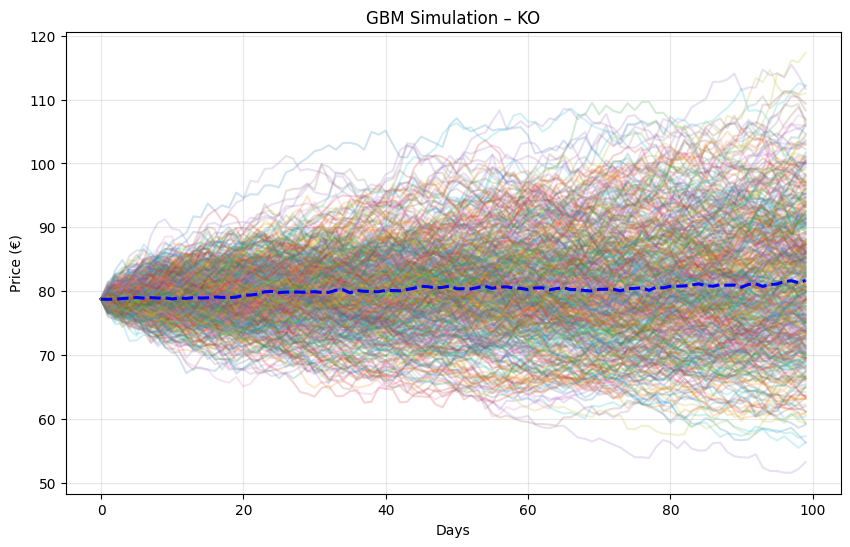

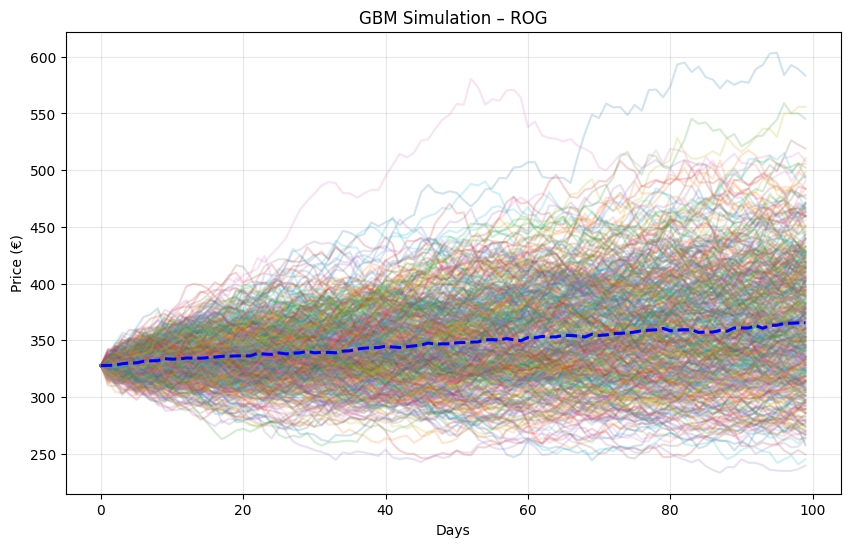

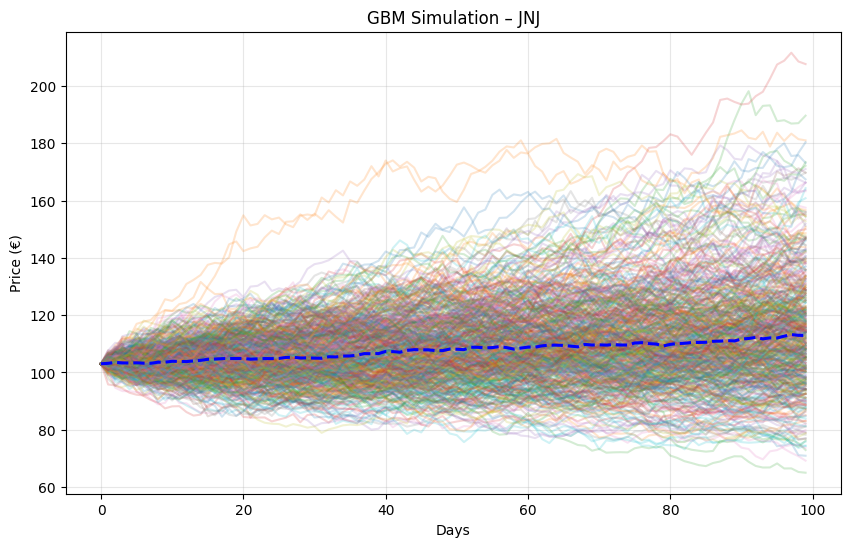

GBM risk per asset (probability >20% drop): [0.002 0.004 0.028 0.01  0.044]


In [5]:
T = 100  # number of days
n_paths = 500 
gbm_risk = []

for i, name in enumerate(stocklist):
    S0 = float(stock_prices.iloc[-1, i])
    mu = float(mean_returns.iloc[i] * 252)
    sigma = float(returns.iloc[:, i].std() * np.sqrt(252))

    gbm_paths = geometric_brownian_motion(S0, mu, sigma, T, n_paths=n_paths)
    prob_drawdown = np.mean(gbm_paths[-1] < 0.8 * S0)
    gbm_risk.append(prob_drawdown)

    median_path = np.median(gbm_paths, axis=1)
    plt.figure(figsize=(10,6))
    plt.plot(gbm_paths, alpha=0.2)
    plt.plot(median_path, linestyle='--', linewidth=2.2, color='blue')
    plt.title(f"GBM Simulation – {name}")
    plt.xlabel("Days")
    plt.ylabel("Price (€)")
    plt.grid(alpha=0.3)
    plt.show(block=False)
    plt.pause(5)
    plt.close()

gbm_risk = np.array(gbm_risk)
print("GBM risk per asset (probability >20% drop):", gbm_risk)


In [6]:
# Risk-adjusted scores
scores = mean_returns / returns.std()
scores *= (1 - returns.corr().mean())  # penalize highly correlated assets
scores *= (1 - gbm_risk)               # penalize risky assets
weights = scores / scores.sum()

for i, asset in enumerate(stocklist):
    print(f"{asset}: {weights.iloc[i]*100:.2f}% in portfolio")


NESN: 36.72% in portfolio
VOW3: 16.34% in portfolio
KO: 7.72% in portfolio
ROG: 21.39% in portfolio
JNJ: 17.83% in portfolio


In [7]:
mc_sims = 1000
initial_portfolio = 10000
mean_matrix = np.tile(mean_returns.values, (T, 1))
portfolio_sims = np.zeros((T, mc_sims))
L = np.linalg.cholesky(cov_matrix)

for m in range(mc_sims):
    Z = np.random.normal(size=(T, len(weights)))
    daily_returns = np.exp(mean_matrix + np.dot(Z, L.T)) - 1
    portfolio_sims[:, m] = np.cumprod(np.dot(daily_returns, weights) + 1) * initial_portfolio

mean_portfolio = np.mean(portfolio_sims, axis=1)
p5 = np.percentile(portfolio_sims, 5, axis=1)
p95 = np.percentile(portfolio_sims, 95, axis=1)


In [8]:
initial_spy = 10000
spy_returns = spy_prices.pct_change().dropna()
spy_mu = (spy_returns.mean() * 252).iloc[0]
spy_sigma = (spy_returns.std() * np.sqrt(252)).iloc[0]
spy_paths = geometric_brownian_motion(initial_spy, spy_mu, spy_sigma, T, n_paths=mc_sims)
spy_mean = np.mean(spy_paths, axis=1)


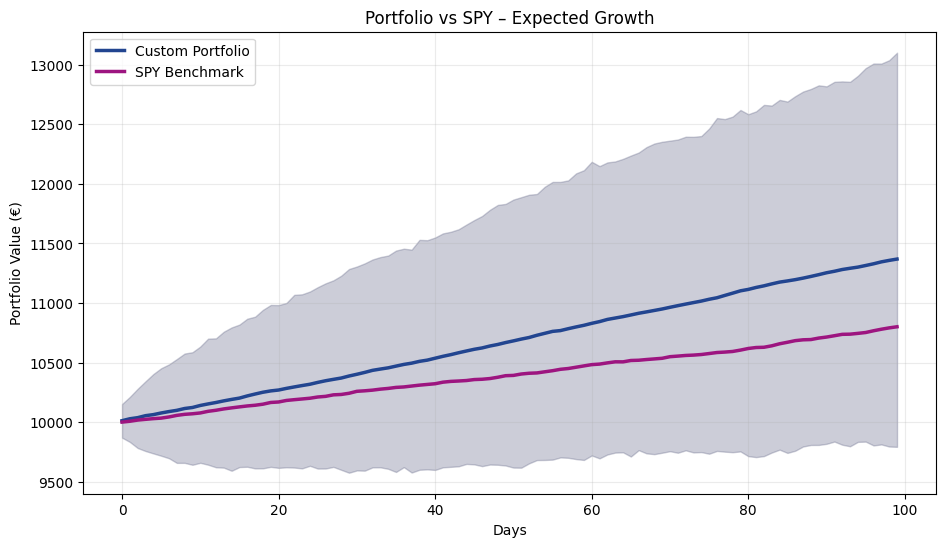

In [9]:
plt.figure(figsize=(11,6))
plt.plot(mean_portfolio, label="Custom Portfolio", linewidth=2.5, color="#224590")
plt.fill_between(range(T), p5, p95, color="#575b7e", alpha=0.3)
plt.plot(spy_mean, label="SPY Benchmark", linewidth=2.5, color="#9D1580")
plt.title("Portfolio vs SPY – Expected Growth")
plt.xlabel("Days")
plt.ylabel("Portfolio Value (€)")
plt.legend()
plt.grid(alpha=0.25)
plt.show()


In [10]:
final_portfolio = portfolio_sims[-1, :]
print("Expected portfolio value (€):", np.mean(final_portfolio))
print("Portfolio standard deviation (€):", np.std(final_portfolio))
print("5th percentile (VaR 95%):", np.percentile(final_portfolio, 5))


Expected portfolio value (€): 11368.782377029456
Portfolio standard deviation (€): 988.0782081190409
5th percentile (VaR 95%): 9792.341797621131
